In [207]:
#load the data
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score


df = pd.read_csv("../classes/variabilites.csv")

N = 295 

df.head()


df['Ground_truth'].value_counts().to_frame().reset_index()

,Ground_truth,count
0,dead,151
1,alive,143


# Threshold optimization

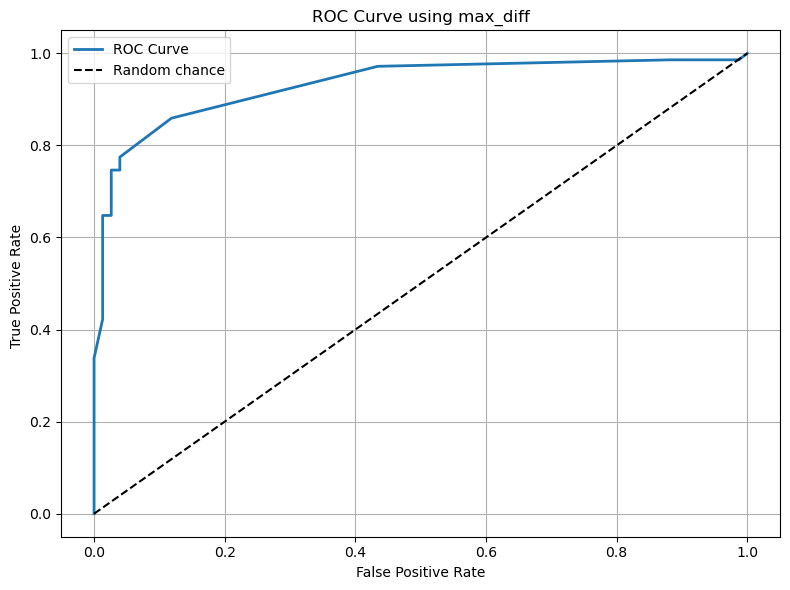

In [208]:
# validation, test split:


# Split data: 30% for threshold optimization, 70% for testing
df_val, df_test = train_test_split(df, test_size=0.5, stratify=df['Ground_truth'])




# ROC curve 

y_true = (df_val['Ground_truth'] == 'alive').astype(int).to_numpy()
y_scores = df_val['max_diff'].to_numpy()





# Compute ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)


# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC Curve', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate ')
plt.title('ROC Curve using max_diff')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




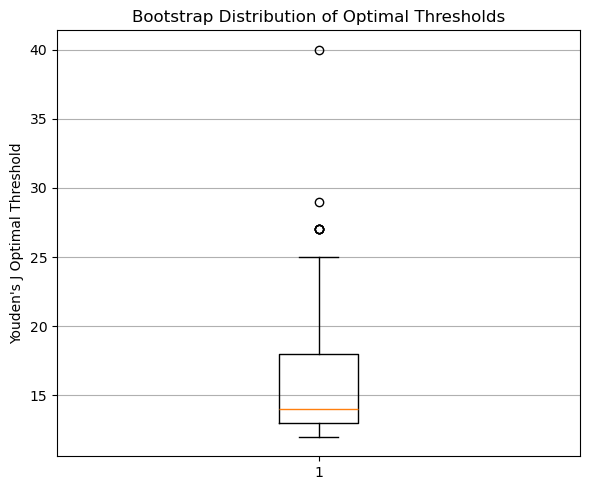

best_threshold: 15.365


In [209]:
n_bootstraps = 1000
rng = np.random.default_rng(42)  # reproducible random number generator


bootstrapped_thresholds = []

for _ in range(n_bootstraps):
    # Sample with replacement from the validation set indices
    indices = rng.integers(0, len(y_true), size=len(y_true))
    y_true_sample = y_true[indices]
    y_scores_sample = y_scores[indices]

    





    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute ROC for the bootstrap sample
    fpr, tpr, thresholds = roc_curve(y_true_sample, y_scores_sample)
    j_scores = tpr - fpr

    if len(j_scores) == 0:
        continue  # skip empty cases (very unlikely)

    best_idx = np.argmax(j_scores)
    best_thresh = thresholds[best_idx]
    bootstrapped_thresholds.append(best_thresh)

# Calculate mean and median threshold
mean_thresh = np.mean(bootstrapped_thresholds)
median_thresh = np.median(bootstrapped_thresholds)


plt.figure(figsize=(6, 5))
plt.boxplot(bootstrapped_thresholds)

plt.ylabel("Youden's J Optimal Threshold")
plt.title("Bootstrap Distribution of Optimal Thresholds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


best_thresh = np.mean(bootstrapped_thresholds)

print("best_threshold:", best_thresh)



# Save best threshold to a text file
with open("../classes/best_threshold.txt", "w") as f:
    f.write(f"{best_thresh:.6f}\n")



# classifier analysis

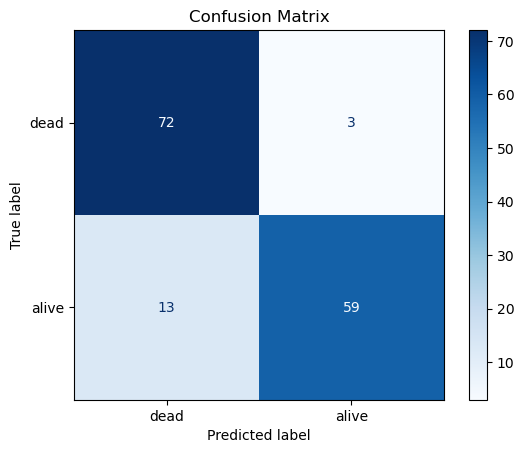

False Positive Rate (FPR): 0.040
False Negative Rate (FNR): 0.181
F1 Score: 0.881
Accuracy: 0.891


In [210]:
# make a confusion matrix
# Plot confusion matrix

y_true_test = (df_test['Ground_truth'] == 'alive').astype(int)
y_pred_test = (df_test['max_diff'] > best_thresh).astype(int)


cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["dead", "alive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




# Calculate confusion matrix components
tn, fp, fn, tp = cm.ravel()

# False Positive Rate (FPR) = FP / (FP + TN)
fpr = fp / (fp + tn)

# False Negative Rate (FNR) = FN / (FN + TP)
fnr = fn / (fn + tp)

# F1 Score
f1 = f1_score(y_true_test, y_pred_test)

# Accuracy
accuracy = accuracy_score(y_true_test, y_pred_test)

print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

# Confidence intervals

C:\Users\mateo\AppData\Local\Temp\ipykernel_46652\1327691215.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies, fprs, fnrs], labels=["Accuracy", "FPR", "FNR"])


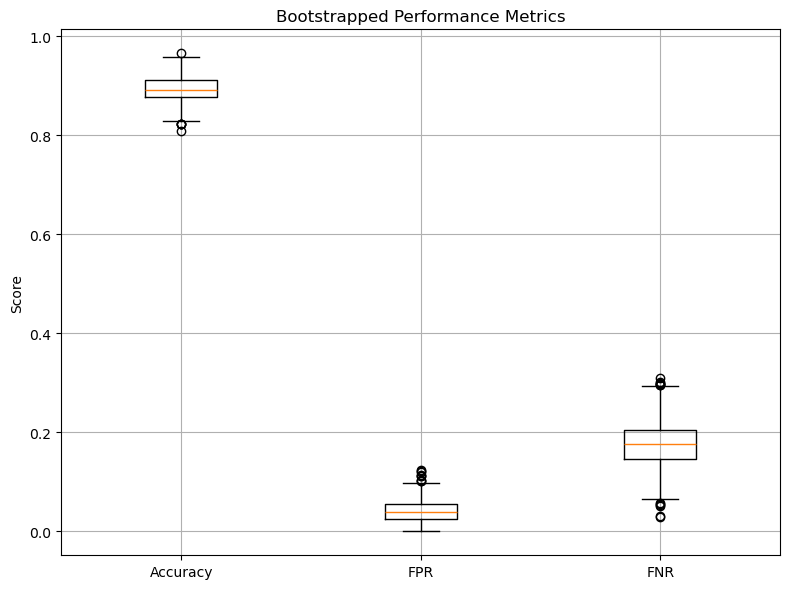

Mean Accuracy: 0.8921
Mean FPR: 0.0411
Mean FNR: 0.1772


In [211]:
# Prepare arrays
n_bootstraps = 1000
accuracies = []
fprs = []
fnrs = []

y_true = (df_test['Ground_truth'] == 'alive').astype(int).values
y_scores = df_test['max_diff'].values
y_pred = (y_scores > best_thresh).astype(int)

rng = np.random.default_rng()

for _ in range(n_bootstraps):
    indices = rng.integers(0, len(y_true), size=len(y_true)) #sample with replacement 1000 times
    y_true_sample = y_true[indices]
    y_pred_sample = y_pred[indices]

    tn, fp, fn, tp = confusion_matrix(y_true_sample, y_pred_sample).ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr_val = fn / (fn + tp) if (fn + tp) > 0 else 0

    accuracies.append(acc)
    fprs.append(fpr_val)
    fnrs.append(fnr_val)


plt.figure(figsize=(8,6))
plt.boxplot([accuracies, fprs, fnrs], labels=["Accuracy", "FPR", "FNR"])
plt.ylabel("Score")
plt.title("Bootstrapped Performance Metrics")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean FPR: {np.mean(fprs):.4f}")
print(f"Mean FNR: {np.mean(fnrs):.4f}")



